# import

In [10]:
from astropy.io import fits
import numpy as np
import torch
from torch import nn, optim
from torch.utils import data
from astropy.nddata.utils import Cutout2D
import glob, os
from esutil import wcsutil
from astropy.table import Table
import pandas as pd
import fitsio
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from random import randint
import math
import sys
from astropy.visualization import hist
from torch.utils.data import DataLoader
from astroML.datasets import fetch_imaging_sample, fetch_sdss_S82standards
import torch.nn.functional as F
import skimage
from tensorboardX import SummaryWriter
from astropy.visualization import MinMaxInterval, SqrtStretch, ZScaleInterval, ImageNormalize


# config

In [11]:
import argparse

# ----------------------------------------
# Global variables within this script
arg_lists = []
parser = argparse.ArgumentParser()


def str2bool(v):
    return v.lower() in ("true", "1")


def add_argument_group(name):
    arg = parser.add_argument_group(name)
    arg_lists.append(arg)
    return arg


# ----------------------------------------
# Arguments for the main program
main_arg = add_argument_group("Main")


main_arg.add_argument("--mode", type=str,
                      default="test",
                      choices=["train", "test"],
                      help="Run mode")

# ----------------------------------------
# Arguments for training
train_arg = add_argument_group("Training")


train_arg.add_argument("--data_dir", type=str,
                       default="/Users/kwang/Downloads/cifar-10-batches-py",
                       help="Directory with CIFAR10 data")

train_arg.add_argument("--learning_rate", type=float,
                       default=1e-5,
                       help="Learning rate (gradient step size)")

train_arg.add_argument("--batch_size", type=int,
                       default=1,
                       help="Size of each training batch")

train_arg.add_argument("--num_epoch", type=int,
                       default=15,
                       help="Number of epochs to train")

train_arg.add_argument("--val_intv", type=int,
                       default=1000,
                       help="Validation interval")

train_arg.add_argument("--rep_intv", type=int,
                       default=150,
                       help="Report interval")

train_arg.add_argument("--log_dir", type=str,
                       default="/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/loss_plot",
                       help="Directory to save logs and current model")

train_arg.add_argument("--save_dir", type=str,
                       default="/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/save",
                       help="Directory to save the best model")

train_arg.add_argument("--resume", type=str2bool,
                       default=True,
                       help="Whether to resume training from existing checkpoint")
# ----------------------------------------
# Arguments for model
model_arg = add_argument_group("Model")

model_arg.add_argument("--feature_type", type=str,
                       default="hog",
                       choices=["hog", "h_histogram", "rgb"],
                       help="Type of feature to be used")

model_arg.add_argument("--loss_type", type=str,
                       default="cross_entropy",
                       choices=["cross_entropy", "svm"],
                       help="Type of data loss to be used")

model_arg.add_argument("--normalize", type=str2bool,
                       default=True,
                       help="Whether to normalize with mean/std or not")

model_arg.add_argument("--l2_reg", type=float,
                       default=1e-3,
                       help="L2 Regularization strength")

model_arg.add_argument("--num_unit", type=int,
                       default=64,
                       help="Number of neurons in the hidden layer")

model_arg.add_argument("--num_hidden", type=int,
                       default=3,
                       help="Number of hidden layers")

model_arg.add_argument("--num_class", type=int,
                       default=10,
                       help="Number of classes in the dataset")

model_arg.add_argument("--activ_type", type=str,
                       default="relu",
                       choices=["relu", "tanh"],
                       help="Activation type")


def get_config():
    config, unparsed = parser.parse_known_args()

    return config, unparsed


def print_usage():
    parser.print_usage()

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class MyUnet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(MyUnet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9,c1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        #out = nn.Sigmoid()(c10)
        return c10

# DataWrap

In [13]:
class PitcairnDataset(data.Dataset):
    def __init__(self, config, mode):
        # mode is "train", "validation" or "test"
        if mode == 'train':
            self.config = config
            print("Loading PitcairnDataset")
            data, label = load_data()
            self.data = data
            self.label = label
            print("done.")
        if mode == 'valid':
            self.config = config
            print("Loading validation PitcairnDataset")
            data, label = load_test_data()
            self.data = data
            self.label = label
            print("done.")            
    
    def __len__(self):
        return (self.data.shape[0])
    
    def __getitem__(self, index):
        data_cur = self.data[index]
        # data
        data_cur = torch.from_numpy(data_cur.astype(np.float32))
        # label
        label_cur = self.label[index]
        return data_cur, label_cur

In [14]:
def load_data():
    # read cfht input images, band u
    os.chdir("/home/yufeng/projects/rrg-kyi/yufeng/image_classification/data/5_bands/cfht")
    data = []
    label = []
    x_slice = 128
    y_slice = 128
    x_num = 78
    y_num = 78
    count=0
    for u_file in glob.glob("*.u.fits"):
        file_id = u_file[5:12] # for example: 189.268
        # load x
        u_data_image = fits.open(u_file, memmap=True)
        r_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/data/5_bands/cfht/CFIS."+file_id+".r.fits"
        r_data_image = fits.open(r_file, memmap=True)
        g_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/data/5_bands/ps/PS1."+file_id+".g.fits"
        g_data_image = fits.open(g_file, memmap=True)
        i_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/data/5_bands/ps/PS1."+file_id+".i.fits"
        i_data_image = fits.open(i_file, memmap=True)
        z_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/data/5_bands/ps/PS1."+file_id+".z.fits"
        z_data_image = fits.open(z_file, memmap=True)
        # load y
        path = '/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/train/label/CFIS.'+file_id+'.fits.fz'
        label_image = fits.open(path)
        # stack 5 channels
        for k in range(1,2):
            #label_image_blur = skimage.filters.gaussian(np.array(label_image[k].data), sigma=0.4, truncate=3.5, multichannel=True)
            for i in range(x_num):
                for j in range(y_num):
                    x_u = np.array(u_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_r = np.array(r_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_g = np.array(g_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_i = np.array(i_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_z = np.array(z_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x = np.stack((x_u, x_r, x_g, x_i, x_z), axis=-1)
                    y = np.array(label_image[k].data[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice,:])
                    if np.any(y>0.5):
                        x = np.nan_to_num(x, nan=-1, posinf=-1, neginf=-1) 
                        nan_pixel = x == -1
                        y[nan_pixel[:,:,:4]] = -1
                        data += [x]
                        label += [y]

        count+=1
        print(count)
        if count==10:
            break
    data = np.array(data)

    data = np.transpose(data, (0, 3, 1, 2))

    label = np.array(label)
    label = np.transpose(label, (0, 3, 1, 2))

    print(np.array(data).shape)
    print(np.array(label).shape)
    return data, label

In [15]:
def load_test_data():
    # read cfht input images, band u
    os.chdir("/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/test/input/cfht")
    data = []
    label = []
    x_slice = 128
    y_slice = 128
    x_num = 78
    y_num = 78

    for u_file in glob.glob("*.u.fits"):
        file_id = u_file[5:12] # for example: 189.268
        # load x
        u_data_image = fits.open(u_file, memmap=True)
        r_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/test/input/cfht/CFIS."+file_id+".r.fits"
        r_data_image = fits.open(r_file, memmap=True)
        g_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/test/input/ps/PS1."+file_id+".g.fits"
        g_data_image = fits.open(g_file, memmap=True)
        i_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/test/input/ps/PS1."+file_id+".i.fits"
        i_data_image = fits.open(i_file, memmap=True)
        z_file = "/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/test/input/ps/PS1."+file_id+".z.fits"
        z_data_image = fits.open(z_file, memmap=True)
        # load y
        path = '/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/data/test/label/CFIS.'+file_id+'.fits.fz'
        label_image = fits.open(path)
        # stack 5 channels
        for k in range(1,2):
            #label_image_blur = skimage.filters.gaussian(np.array(label_image[k].data), sigma=0.4, truncate=3.5, multichannel=True)
            for i in range(x_num):
                for j in range(y_num):
                    x_u = np.array(u_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_r = np.array(r_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_g = np.array(g_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_i = np.array(i_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x_z = np.array(z_data_image[0].data.T[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice])
                    x = np.stack((x_u, x_r, x_g, x_i, x_z), axis=-1)
                    y = np.array(label_image[k].data[i*x_slice:(i+1)*x_slice, j*y_slice:(j+1)*y_slice,:])
                    if np.any(y>0.5):
                        x = np.nan_to_num(x, nan=-1, posinf=-1, neginf=-1) 
                        nan_pixel = x == -1
                        y[nan_pixel[:,:,:4]] = -1
                        data += [x]
                        label += [y]
        break
    data = np.array(data)
    
    data = np.transpose(data, (0, 3, 1, 2))

    label = np.array(label)
    label = np.transpose(label, (0, 3, 1, 2))

    print(np.array(data).shape)
    print(np.array(label).shape)
    return data, label

# solution

In [16]:
def train(config):
    train_data = PitcairnDataset(config, mode="train")
    valid_data = PitcairnDataset(config, mode="valid")
    inc = 5
    outc = 4
    best_acc = 0
    model = MyUnet(inc, outc)
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    tr_data_loader = DataLoader(
        dataset=train_data,
        batch_size=config.batch_size,
        num_workers=2,
        shuffle=True)
    
    va_data_loader = DataLoader(
        dataset=valid_data,
        batch_size=config.batch_size,
        num_workers=2,
        shuffle=False)
    
    model.train()
    
    #loss = nn.PoissonNLLLoss()
    loss = nn.KLDivLoss()
    
    optimizer = optim.Adam(model.parameters(), lr = config.learning_rate)
    
    bestmodel_file = os.path.join(config.save_dir, "best_model.pth")
    
    iter_idx = -1
    tr_writer = SummaryWriter(
        log_dir=os.path.join(config.log_dir, "train"))
    va_writer = SummaryWriter(
        log_dir=os.path.join(config.log_dir, "valid"))
    acc_writer = SummaryWriter(
        log_dir=os.path.join(config.log_dir, "accuracy")) 
    total_train_loss = 0
    total_val_loss = []
    train_count = 0
    val_count = 0
    for epoch in range(config.num_epoch):
        print(epoch)

        prefix = "Training Epoch {:3d}: ".format(epoch)
        for data in tr_data_loader:
            iter_idx += 1
            x, y = data
            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            
            logits = model.forward(x)
            
            m = nn.Softmax2d()
            logits = m(logits)
            logits = torch.log(logits)
            # data: 0.25, nan, label pixel
            
            temp_x = logits.detach().cpu().numpy()
            temp_y = y.detach().cpu().numpy()
            
            pixel1 = temp_y != 0.25
            pixel2 = temp_y != -1
            label_pixel = pixel1 & pixel2
            nan_pixel = temp_y == -1
            other_pixel = temp_y == 0.25
     
            weights_nan_pixel = 0

            weights_label = float(temp_y[other_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0]))
            weights_other = float(temp_y[label_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0]))
            logits = logits.float()
            y = y.float()
            output_loss = weights_label*loss(logits[[label_pixel]], y[[label_pixel]])+weights_other*loss(logits[[other_pixel]], y[[other_pixel]])

            output_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += output_loss
            train_count += 1
            if iter_idx % config.rep_intv == 0:
                mean_output_loss = total_train_loss/train_count
                tr_writer.add_scalar("loss", mean_output_loss, global_step=iter_idx)
                print("training loss: " + str(mean_output_loss))
                #print('prediction: ')
                #print(np.exp(temp_x)[label_pixel])
                #print('label: ')
                #print(temp_y[label_pixel])
                total_train_loss = 0
                train_count = 0
                total_count = 0
                true_count = 0
                wrong_count = 0
                model = model.eval()
                for data in va_data_loader:
                    x, y = data
                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()
                    with torch.no_grad():
                        logits = model.forward(x)
            
                        m = nn.Softmax2d()
                        logits = m(logits)
                        logits = torch.log(logits)

                        temp_x = logits.detach().cpu().numpy()
                        temp_y = y.detach().cpu().numpy()

                        pixel1 = temp_y != 0.25
                        pixel2 = temp_y != -1
                        label_pixel = pixel1 & pixel2
                        nan_pixel = temp_y == -1
                        other_pixel = temp_y == 0.25

                        weights_nan_pixel = 0
                        
                        # accuracy
                        pred = torch.argmax(torch.exp(logits)[[label_pixel]])
                        yy = torch.argmax(y[[label_pixel]])
                        acc = yy.eq(pred).cpu().sum()
                        true_count += acc.cpu().numpy()
                        wrong_count += (acc.cpu().numpy()-1)
                        total_count += 1
                        weights_label = temp_y[other_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0])
                        weights_other = temp_y[label_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0])

                        va_output_loss = weights_label*loss(logits[[label_pixel]], y[[label_pixel]])+weights_other*loss(logits[[other_pixel]], y[[other_pixel]])
                        if (va_output_loss == math.inf) | (math.isnan(va_output_loss)):
                            continue
                        total_val_loss += [va_output_loss.cpu().numpy()]
                        val_count += 1
                #print('validation prediction: ')
                #print(np.exp(temp_x)[label_pixel])
                #print('validation label: ')
                #print(temp_y[label_pixel])
                        mean_val_loss = np.mean(total_val_loss)
                print('validation loss:'+str(mean_val_loss))
                va_writer.add_scalar("validation loss", mean_val_loss, global_step=iter_idx)
                accuracy = (true_count/total_count)*100.0
                if accuracy > best_acc:
                    best_acc = accuracy
                    torch.save({
                        "model": model.state_dict(),
                    }, bestmodel_file)
                acc_writer.add_scalar("accuracy ", accuracy, global_step=iter_idx)
                print('accuracy: ' + str(accuracy) + '%')
                total_val_loss = []
                val_count = 0
                model = model.train()
    print('best accuracy: ' + str(best_acc) + '%')

In [17]:
def test(config):
    galaxy = 0
    quasar = 0
    star = 0
    predict_galaxy = 0
    predict_quasar = 0
    predict_star = 0
    
    inc = 5
    outc = 4
    total_val_loss = []
    val_count = 0
    total_count = 0
    true_count = 0
    wrong_count = 0
    hdu_list = []
    valid_data = PitcairnDataset(config, mode="valid")
    
    va_data_loader = DataLoader(
        dataset=valid_data,
        batch_size=config.batch_size,
        num_workers=2,
        shuffle=False)
    
    model = MyUnet(inc, outc)
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    load_res = torch.load(os.path.join(config.save_dir, "best_model.pth"))
    model.load_state_dict(load_res["model"])
    model.eval()
    #loss = nn.PoissonNLLLoss()
    loss = nn.KLDivLoss()
    
    for data in va_data_loader:
        x, y = data
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        with torch.no_grad():            
            logits = model.forward(x)
            m = nn.Softmax2d()
            logits = m(logits)
            logits = torch.log(logits)
 
            temp_x = logits.detach().cpu().numpy()
            temp_y = y.detach().cpu().numpy()

            pixel1 = temp_y != 0.25
            pixel2 = temp_y != -1
            label_pixel = pixel1 & pixel2
            nan_pixel = temp_y == -1
            other_pixel = temp_y == 0.25
            
            label_class_index = np.where((temp_y != 0.25) & (temp_y != -1))
            label_class = temp_y[np.where((temp_y != 0.25) & (temp_y != -1))]
            label_x = label_class_index[3][0]
            label_y = label_class_index[2][0]
            label_class_id = np.argmax(label_class)

            image_u = np.transpose(x.detach().cpu().numpy(), (0, 2, 3, 1))[0,:,:,0]
            image_r = np.transpose(x.detach().cpu().numpy(), (0, 2, 3, 1))[0,:,:,1]
            image_g = np.transpose(x.detach().cpu().numpy(), (0, 2, 3, 1))[0,:,:,2]
            image_i = np.transpose(x.detach().cpu().numpy(), (0, 2, 3, 1))[0,:,:,3]
            image_z = np.transpose(x.detach().cpu().numpy(), (0, 2, 3, 1))[0,:,:,4]
            # plot original images
            norm = ImageNormalize(image, interval=ZScaleInterval(),
                      stretch=SqrtStretch())
            plt.imshow(image_r, cmap='gray', norm=norm)
            plt.show()
            image_ls = [image_u, image_r, image_g, image_i, image_z]
            band_ls = ['u','r', 'g', 'i', 'z']
            fig = plt.figure(figsize=(25, 25))
            ax = []
            count_i = 0
            #circle2 = plt.Circle((5, 5), 0.5, color='b', fill=False)
            tmp = np.array(np.where(np.exp(temp_x) >= 0.5))

            quasar_class_x = []
            quasar_class_y = []
            star_class_x = []
            star_class_y = []
            galaxy_class_x = []
            galaxy_class_y = []
            
            for (band,image) in zip(band_ls,image_ls):
                tmp_ax = fig.add_subplot(1, 5, count_i+1)
                ax.append(tmp_ax)
                ax[-1].set_title("band:"+str(band))
                # plot label circle
                if label_class_id == 0:
                    circle = plt.Circle((label_x, label_y), 15, color='g', fill=False)
                    tmp_ax.add_patch(circle)
                elif label_class_id == 1:
                    circle = plt.Circle((label_x, label_y), 15, color='r', fill=False)
                    tmp_ax.add_patch(circle)
                elif label_class_id == 2:
                    circle = plt.Circle((label_x, label_y), 15, color='b', fill=False)
                    tmp_ax.add_patch(circle)

                # plot prediction circle
                if tmp.size > 0:
                    for i in range(tmp.shape[1]):
                        if tmp[1,i] == 0: # 2: galaxy 1: star  0: quasar
                            #print('circle('+str(tmp[3,i])+','+str(tmp[2,i])+',10) # color = green')
                            circle = plt.Circle((tmp[3,i], tmp[2,i]), 0.5, color='g', fill=False)
                            quasar_class_x.append(tmp[3,i])
                            quasar_class_y.append(120-tmp[2,i])
                            tmp_ax.add_patch(circle)

                        elif tmp[1,i] == 1:
                            #print('circle('+str(tmp[3,i])+','+str(tmp[2,i])+',10) # color = red')
                            circle = plt.Circle((tmp[3,i], tmp[2,i]), 0.5, color='r', fill=False)
                            star_class_x.append(tmp[3,i])
                            star_class_y.append(120-tmp[2,i])
                            tmp_ax.add_patch(circle)

                        elif tmp [1,i] == 2:
                            #print('circle('+str(tmp[3,i])+','+str(tmp[2,i])+',10) # color = blue')
                            circle = plt.Circle((tmp[3,i], tmp[2,i]), 0.5, color='b', fill=False)
                            galaxy_class_x.append(tmp[3,i])
                            galaxy_class_y.append(120-tmp[2,i])
                            tmp_ax.add_patch(circle)

                plt.imshow(image, cmap='gray')
                count_i += 1
            
            plt.show() 

            plt.xlim(0,128)
            plt.ylim(0,128)
            sns.set_style("white")
            sns.kdeplot(quasar_class_x, quasar_class_y, cmap="Greens", shade=True, shade_lowest=True, )
            plt.show()

            plt.xlim(0,128)
            plt.ylim(0,128)
            sns.kdeplot(star_class_x, star_class_y, cmap="Reds", shade=True, shade_lowest=True, )
            plt.show()

            plt.xlim(0,128)
            plt.ylim(0,128)
            sns.kdeplot(galaxy_class_x, galaxy_class_y, cmap="Blues", shade=True, shade_lowest=True, )
            plt.show()
            #circle(1046.9408690733712,1428.1269110415067,5) # color = blue
            #primary = fits.PrimaryHDU()
            #hdu_list.append(primary)
            #hdu = fits.ImageHDU(image_x)
            #hdu_list.append(hdu)
            #savename = '/home/yufeng/projects/rrg-kyi/yufeng/image_classification/unet/visualization/sample_u.fits.fz'
            #hdul = fits.HDUList(hdu_list)
            #hdul.writeto(savename)

            weights_nan_pixel = 0
            pred = torch.argmax(torch.exp(logits)[[label_pixel]])
            yy = torch.argmax(y[[label_pixel]])

            acc = yy.eq(pred).cpu().sum()
            true_count += acc.cpu().numpy()
            wrong_count += (acc.cpu().numpy()-1)
            total_count += 1
            weights_label = temp_y[other_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0])
            weights_other = temp_y[label_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0])

            va_output_loss = weights_label*loss(logits[[label_pixel]], y[[label_pixel]])+weights_other*loss(logits[[other_pixel]], y[[other_pixel]])
            if (va_output_loss == math.inf) | (math.isnan(va_output_loss)):
                continue
            total_val_loss += [va_output_loss.cpu().numpy()]
            val_count += 1
            mean_val_loss = np.mean(total_val_loss)
            
    print('test loss: '+str(mean_val_loss))
    accuracy = (true_count/total_count)*100.0
    print('accuracy: ' + str(accuracy))
    total_val_loss = []
    val_count = 0

In [9]:
def test(config):
    galaxy = 0
    quasar = 0
    star = 0
    predict_galaxy = 0
    predict_quasar = 0
    predict_star = 0
    
    inc = 5
    outc = 4
    total_val_loss = []
    val_count = 0
    total_count = 0
    true_count = 0
    wrong_count = 0
    hdu_list = []
    valid_data = PitcairnDataset(config, mode="valid")
    
    va_data_loader = DataLoader(
        dataset=valid_data,
        batch_size=config.batch_size,
        num_workers=2,
        shuffle=False)
    
    model = MyUnet(inc, outc)
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    load_res = torch.load(os.path.join(config.save_dir, "best_model.pth"))
    model.load_state_dict(load_res["model"])
    model.eval()
    #loss = nn.PoissonNLLLoss()
    loss = nn.KLDivLoss()
    
    for data in va_data_loader:
        x, y = data
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        with torch.no_grad():            
            logits = model.forward(x)
            m = nn.Softmax2d()
            logits = m(logits)
            logits = torch.log(logits)
 
            temp_x = logits.detach().cpu().numpy()
            temp_y = y.detach().cpu().numpy()

            pixel1 = temp_y != 0.25
            pixel2 = temp_y != -1
            label_pixel = pixel1 & pixel2
            nan_pixel = temp_y == -1
            other_pixel = temp_y == 0.25
            
            weights_nan_pixel = 0
            pred = torch.argmax(torch.exp(logits)[[label_pixel]])
            yy = torch.argmax(y[[label_pixel]])
            
            if yy == 0:
                quasar+=1
                if pred == 0:
                    predict_quasar+=1
            elif yy == 1:
                star+=1
                if pred == 1:
                    predict_star+=1
            elif yy == 2:
                galaxy+=1
                if pred == 2:
                    predict_galaxy+=1
            
            acc = yy.eq(pred).cpu().sum()
            true_count += acc.cpu().numpy()
            wrong_count += (acc.cpu().numpy()-1)
            total_count += 1
            weights_label = temp_y[other_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0])
            weights_other = temp_y[label_pixel].shape[0] / (temp_y[label_pixel].shape[0]+temp_y[other_pixel].shape[0])

            va_output_loss = weights_label*loss(logits[[label_pixel]], y[[label_pixel]])+weights_other*loss(logits[[other_pixel]], y[[other_pixel]])
            if (va_output_loss == math.inf) | (math.isnan(va_output_loss)):
                continue
            total_val_loss += [va_output_loss.cpu().numpy()]
            val_count += 1
            mean_val_loss = np.mean(total_val_loss)
            
    print('test loss: '+str(mean_val_loss))
    accuracy = (true_count/total_count)*100.0
    print('accuracy: ' + str(accuracy))
    total_val_loss = []
    val_count = 0
    
    print('there are ' + str(total_count) + ' objects in the test set')
    print('there are ' + str(quasar) + ' quasars totally, and ' + str(predict_quasar) + ' of them are predicted as quasar')
    print('there are ' + str(star) + ' stars totally, and ' + str(predict_star) + ' of them are predicted as star')
    print('there are ' + str(galaxy) + ' galaxies totally, and ' + str(predict_galaxy) + ' of them are predicted as galaxy')
    print('overall precision is '+ str(accuracy))
    

# main

In [18]:
def main(config):
    """The main function."""

    if config.mode == "train":
        train(config)
    elif config.mode == "test":
        test(config)
    else:
        raise ValueError("Unknown run mode \"{}\"".format(config.mode))


if __name__ == "__main__":

    # ----------------------------------------
    # Parse configuration
    config, unparsed = get_config()
    # If we have unparsed arguments, print usage and exit
    if len(unparsed) > 0:
        print_usage()
        exit(1)

    main(config)

usage: ipykernel_launcher.py [-h] [--mode {train,test}] [--data_dir DATA_DIR]
                             [--learning_rate LEARNING_RATE]
                             [--batch_size BATCH_SIZE] [--num_epoch NUM_EPOCH]
                             [--val_intv VAL_INTV] [--rep_intv REP_INTV]
                             [--log_dir LOG_DIR] [--save_dir SAVE_DIR]
                             [--resume RESUME]
                             [--feature_type {hog,h_histogram,rgb}]
                             [--loss_type {cross_entropy,svm}]
                             [--normalize NORMALIZE] [--l2_reg L2_REG]
                             [--num_unit NUM_UNIT] [--num_hidden NUM_HIDDEN]
                             [--num_class NUM_CLASS]
                             [--activ_type {relu,tanh}]
Loading validation PitcairnDataset
(248, 5, 128, 128)
(248, 4, 128, 128)
done.


UnboundLocalError: local variable 'image' referenced before assignment

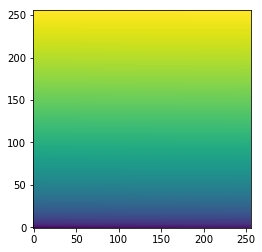

In [7]:
image = np.arange(65536).reshape((256, 256))

# Create an ImageNormalize object
norm = ImageNormalize(image, interval=ZScaleInterval(),
                      stretch=SqrtStretch())

# or equivalently using positional arguments
# norm = ImageNormalize(image, MinMaxInterval(), SqrtStretch())

# Display the image
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(image, origin='lower', norm=norm)